In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier #,Ridge,Lasso,ElasticNet
from sklearn.metrics import accuracy_score,recall_score,precision_score,roc_auc_score,f1_score,confusion_matrix
from sklearn.model_selection import train_test_split,cross_val_score,KFold,RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from imblearn.over_sampling import ADASYN,KMeansSMOTE,SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.datasets import make_classification
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
import numpy as np
import pyreadstat
from collections import Counter

In [2]:
df = pd.read_csv("C:\\Users\\kiran\\Downloads\\loan_fraud.csv")

In [3]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
df.shape

(284807, 31)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
X_col = df.drop(columns = 'Class')
y_col = df['Class']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_col, y_col, test_size=0.20, random_state=42)

In [8]:
y_train.value_counts()

Class
0    227451
1       394
Name: count, dtype: int64

In [9]:
def KmeansSmote(X,y):
    kmeans_smote = KMeansSMOTE(
    sampling_strategy='auto',  # Resamples the minority class
    random_state=42,
    kmeans_estimator=10,  # Number of KMeans clusters to use
    cluster_balance_threshold=0.01,  # Threshold below which to balance clusters
    n_jobs=-1  # Use all available cores
    )

    # Apply the resampler on the training data
    X_resampled, y_resampled = kmeans_smote.fit_resample(X_train, y_train)
    return X_resampled,y_resampled

In [10]:
def oversample_with_adasyn(X, y, target_minority_samples=180000):
    """
    Oversample the minority class using ADASYN until the minority class reaches the target_minority_samples.
    
    Parameters:
    - X: Feature matrix
    - y: Target vector
    - target_minority_samples: Desired number of samples for the minority class after oversampling
    
    Returns:
    - X_resampled, y_resampled: Feature matrix and target vector after resampling
    """
    # Identify minority class
    classes, counts = np.unique(y, return_counts=True)
    minority_class = classes[np.argmin(counts)]
    current_minority_samples = counts[np.argmin(counts)]

    # Calculate how many new samples we need to generate for the minority class
    if current_minority_samples >= target_minority_samples:
        raise ValueError("The minority class already has more or equal samples than the target_minority_samples.")
    
    n_samples_to_generate = target_minority_samples - current_minority_samples

    # Set the sampling strategy for ADASYN
    # This will tell ADASYN to generate the specified number of samples for the minority class
    sampling_strategy = {minority_class: n_samples_to_generate}

    # Create the ADASYN instance and fit it to the data
    adasyn = ADASYN(sampling_strategy=sampling_strategy, n_neighbors=5, random_state=42)
    X_resampled, y_resampled = adasyn.fit_resample(X, y)

    return X_resampled, y_resampled

In [11]:
def undersample_with_nearmiss(X, y):
    """
    Undersample the majority class using NearMiss until it is balanced with the minority class.
    
    Parameters:
    - X: Feature matrix
    - y: Target vector
    
    Returns:
    - X_resampled, y_resampled: Feature matrix and target vector after resampling
    """
    # Identify majority and minority classes
    classes, counts = np.unique(y, return_counts=True)
    minority_class_count = min(counts)
    
    # Set the sampling strategy for NearMiss
    # This will balance the majority class with the minority class
    nm = NearMiss()
    
    # Perform the undersampling
    X_resampled, y_resampled = nm.fit_resample(X, y)
    
    # Check if undersampling was successful
    if len(np.unique(y_resampled, return_counts=True)[1]) != 2 or np.unique(y_resampled, return_counts=True)[1][0] != minority_class_count:
        raise ValueError("NearMiss did not undersample correctly.")
    
    return X_resampled, y_resampled

In [12]:
X_resampled,y_resampled = oversample_with_adasyn(X_train,y_train)

In [13]:
y_resampled.value_counts()

Class
0    227451
1    179696
Name: count, dtype: int64

In [16]:
X_train,y_train = undersample_with_nearmiss(X_resampled,y_resampled)

In [17]:
#X_train,y_train = KmeansSmote(X_train,y_train)

In [25]:
y_train.value_counts()

Class
0    179696
1    179696
Name: count, dtype: int64

In [19]:
scaler = StandardScaler()

In [20]:
scaler.fit(X_train)

StandardScaler()

In [21]:
X_train_scaled = scaler.transform(X_train)
X_train = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)

In [22]:
X_test_scaled = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

In [29]:
logr = LogisticRegression()
logr.fit(X_train,y_train)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,logr.predict(X_train))))
print('Precision of training is '+ str(precision_score(y_train,logr.predict(X_train))))
print('Recall of training is '+ str(recall_score(y_train,logr.predict(X_train))))
print('F1 of training is '+ str(f1_score(y_train,logr.predict(X_train))))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,logr.predict(X_train))))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,logr.predict(X_test))))
print('Precision of test is '+ str(precision_score(y_test,logr.predict(X_test))))
print('Recall of test is '+ str(recall_score(y_test,logr.predict(X_test))))
print('F1 of test is '+ str(f1_score(y_test,logr.predict(X_test))))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,logr.predict(X_test))))

threshold = 0.8  # Adjust this threshold
y_pred_adjusted = (logr.predict(X_test) > threshold).astype(int)

print(f"Adjusted Precision: {precision_score(y_test, y_pred_adjusted)}")
print(f"Adjusted Recall: {recall_score(y_test, y_pred_adjusted)}")

Accuracy of training is 0.9802638901255454
Precision of training is 0.991228619404047
Recall of training is 0.9691033745881934
F1 of training is 0.9800411389466516
ROC AUC of training is 0.9802638901255454

Accuracy of test is 0.9754046557354026
Precision of test is 0.06127946127946128
Recall of test is 0.9285714285714286
F1 of test is 0.114971572962729
ROC AUC of test is 0.9520283985850954
Adjusted Precision: 0.06127946127946128
Adjusted Recall: 0.9285714285714286


C:\Users\kiran\AppData\Roaming\Python\Python311\site-packages\sklearn\linear_model\_logistic.py:1175: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


Accuracy of training is 0.999223156092958
Precision of training is 0.7847769028871391
Recall of training is 0.7588832487309645
F1 of training is 0.7716129032258064
ROC AUC of training is 0.8792613657603321

Accuracy of test is 0.9992977774656788
Precision of test is 0.8152173913043478
Recall of test is 0.7653061224489796
F1 of test is 0.7894736842105263
ROC AUC of test is 0.8825035817647262


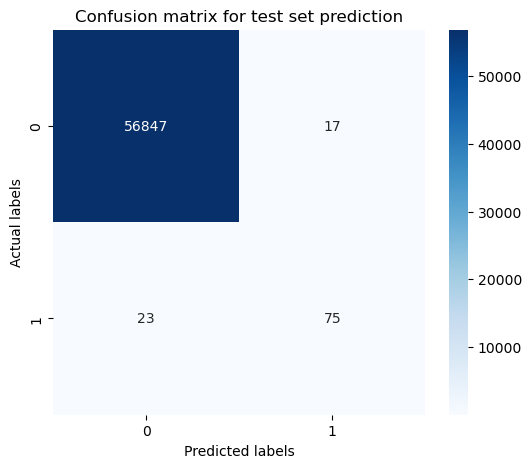

In [12]:
#Logistic regression with hyperparameter tuning
logr_regression = LogisticRegression(solver='saga',max_iter=500)

#Define grid of hyperparameters
parameter = {'logisticregression__C':[0.001,0.01,0.1,1,10,100],'logisticregression__penalty':['l1','l2','elasticnet'],'logisticregression__l1_ratio': [0, 0.25, 0.5, 0.75, 1],'logisticregression__class_weight': [None, 'balanced', {0: 1, 1: 10}, {0: 1, 1: 20}, {0: 1, 1: 50}]}

pipeline = make_pipeline(StandardScaler(),logr_regression)

random_search = RandomizedSearchCV(estimator=pipeline,param_distributions=parameter,cv=3,scoring='precision',n_jobs=-1,n_iter=5,random_state=42)

#subset = len(X_train) // 10
#Fitting Linear Regression
random_search.fit(X_train,y_train)

check_params = random_search.best_params_
check_model = random_search.best_estimator_

#Predicting the test data
y_train_predict = check_model.predict(X_train)
y_predict = check_model.predict(X_test)

#Printing errors
print('Accuracy of training is '+ str(accuracy_score(y_train,y_train_predict)))
print('Precision of training is '+ str(precision_score(y_train,y_train_predict)))
print('Recall of training is '+ str(recall_score(y_train,y_train_predict)))
print('F1 of training is '+ str(f1_score(y_train,y_train_predict)))
print('ROC AUC of training is '+ str(roc_auc_score(y_train,y_train_predict)))
print()
print('Accuracy of test is '+ str(accuracy_score(y_test,y_predict)))
print('Precision of test is '+ str(precision_score(y_test,y_predict)))
print('Recall of test is '+ str(recall_score(y_test,y_predict)))
print('F1 of test is '+ str(f1_score(y_test,y_predict)))
print('ROC AUC of test is '+ str(roc_auc_score(y_test,y_predict)))


#Computing confusion matrix for the test set prediction
Confusion_matrix_test = confusion_matrix(y_test,y_predict)

#plotting the confusion matrix for the test set prediction
plt.figure(figsize=(6,5))
sns.heatmap(Confusion_matrix_test,annot=True,fmt='g',cmap='Blues',cbar=True)
plt.title('Confusion matrix for test set prediction')
plt.xlabel('Predicted labels')
plt.ylabel('Actual labels')
plt.show()

In [10]:
minority_class = 1
minority_indices = np.where(y_train == minority_class)[0]

X_minority_train = X_train.iloc[minority_indices]
y_minority_train = y_train.iloc[minority_indices]

In [11]:
# Initialize KMeans
n_clusters = 5  # Adjust based on your dataset
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
clusters = kmeans.fit_predict(X_minority_train)

# Oversample within each identified cluster using SMOTE
smote = SMOTE(random_state=42)
X_oversampled_list, y_oversampled_list = [], []

for cluster in range(n_clusters):
    cluster_indices = np.where(clusters == cluster)[0]
    X_cluster = X_minority_train.iloc[cluster_indices]
    y_cluster = y_minority_train.iloc[cluster_indices]
    if len(X_cluster) > 1:  # SMOTE needs at least 2 samples
        X_res, y_res = smote.fit_resample(X_cluster, y_cluster)
        X_oversampled_list.append(X_res)
        y_oversampled_list.append(y_res)

# Combine oversampled clusters back into the training set
X_oversampled = pd.concat(X_oversampled_list, ignore_index=True)
y_oversampled = pd.concat(y_oversampled_list, ignore_index=True)

# Concatenate the oversampled minority class with the rest of the training data
X_train_balanced = pd.concat([X_train.drop(minority_indices, axis=0), X_oversampled])
y_train_balanced = pd.concat([y_train.drop(minority_indices, axis=0), y_oversampled])

C:\Users\kiran\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


ValueError: The target 'y' needs to have more than 1 class. Got 1 class instead